<a href="https://colab.research.google.com/github/Harshitha-Lingala/Skin-Cancer-Lesions-Classification/blob/main/PCA_and_age_standardization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Engineering Plan

1.   Age normalization - [0,1]
2.   PCA for image with image pixel norm - [0,1]


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import storage
storage_client = storage.Client()

In [ ]:
import pandas as pd
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
bucket = storage_client.get_bucket('ham10000dataset')
blob_metadata = bucket.blob('HAM10000_metadata_cleaned.csv')
local_cleaned_metadata_location = '/tmp/HAM10000_metadata.csv'
blob_metadata.download_to_filename(local_cleaned_metadata_location)


In [ ]:
df_metadata = pd.read_csv(local_cleaned_metadata_location)

In [ ]:
df_metadata.head()

,lesion_id,image_id,skin_cancer_type,dx_type,age,sex,localization,image_path,clean_image_path
0,HAM_0000118,ISIC_0027419,2,histo,80.0,1,scalp,HAM10000_images/ISIC_0027419.jpg,HAM10000_images_clean/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,2,histo,80.0,1,scalp,HAM10000_images/ISIC_0025030.jpg,HAM10000_images_clean/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,2,histo,80.0,1,scalp,HAM10000_images/ISIC_0026769.jpg,HAM10000_images_clean/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,2,histo,80.0,1,scalp,HAM10000_images/ISIC_0025661.jpg,HAM10000_images_clean/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,2,histo,75.0,1,ear,HAM10000_images/ISIC_0031633.jpg,HAM10000_images_clean/ISIC_0031633.jpg


DATA Normalization - for age [0,1] - MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_metadata[['age_scaled']] = scaler.fit_transform(df_metadata[['age']])

In [ ]:
df_metadata.age_scaled.describe()

count    10015.000000
mean         0.588271
std          0.207737
min          0.000000
25%          0.437500
50%          0.562500
75%          0.750000
max          1.000000
Name: age_scaled, dtype: float64

IMAGES - normlaize pixel values [0,1] - MinMaxScaler
Perform PCA for dimensionality reduction



In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import io
import cv2

Trials - Performing normalization and PCA for 1 image

In [ ]:
df_metadata.loc[500,'clean_image_path']

'HAM10000_images_clean/ISIC_0025781.jpg'

In [ ]:
## load image from GCP
image = bucket.blob('HAM10000_images_clean/ISIC_0025781.jpg')
image_bytes = image.download_as_bytes()
## convert the image to an array
image_np = np.frombuffer(image_bytes, np.uint8)
## read using OpenCV library
image_cv2 = cv2.imdecode(image_np, cv2.IMREAD_COLOR)
# Flatten the image
flattened_image = image_cv2.flatten()

In [ ]:
## Apply scaling MinMaxScaler for the elements of the image
flattened_image = flattened_image.reshape(810000,1)
## Fit to MinMaxScaler model
scaled_image = scaler.fit_transform(flattened_image)

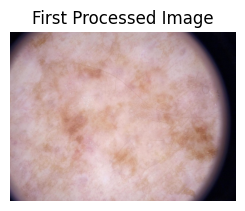

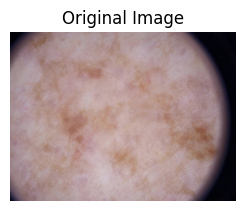

In [ ]:
## Reconstruct and reshape the scaled image back to the original size for visualization

scaled_image_rec = (scaled_image * 255).astype(np.uint8).reshape(450, 600, 3)

# Plot the Scaled image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(scaled_image_rec, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for displaying
plt.title('First Processed Image')
plt.axis('off')
plt.show()

# Plot the original image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_cv2,cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

In [ ]:
# Initialize PCA, choose the number of components
# n_components <= min(810000,1)

pca = PCA(n_components=0.85)
image_pca_components = pca.fit(scaled_image)


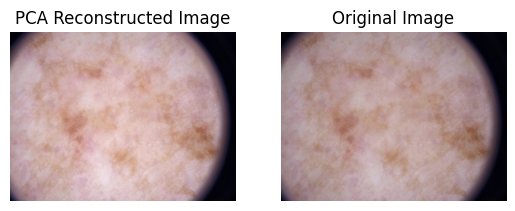

In [ ]:
# Rescale and reshape the PCA reduced image

components = image_pca_components.transform(scaled_image)
projected = image_pca_components.inverse_transform(components)

image_re = (projected * 255).astype(np.uint8).reshape(450, 600, 3)

# Plot the PCA Reconstructed image
plt.subplot(1, 2, 1)
plt.title('PCA Reconstructed Image')
plt.imshow(cv2.cvtColor(image_re, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Plot the original image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_cv2,cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()
